# TASK: Detection of COVID-19

The goal of this task is to detect if a patient has COVID-19 based on their vitals. Thus, this is a task of binary classification

## Necessary imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import seaborn as sb
import matplotlib.pyplot as plt
import datetime
from datetime import date
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

## Data Preparation

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data preprocessing

In [ ]:
# Loading encounters dataset
encounters_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/covid19/encounters.csv') 

In [ ]:
# Shape of the dataset
print("Size of Encounters dataset is: ", encounters_df.shape)
encounters_df.head()

Size of Encounters dataset is:  (3188675, 15)


,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,d317dacb-d801-4136-be7d-440094f7ae83,2019-02-16T01:43:20Z,2019-02-16T01:58:20Z,1ff7f10f-a204-4bb1-aa72-dd763fa99482,5103c940-0c08-392f-95cd-446e0cea042a,8b532fbe-4254-3a60-a442-33028916d24e,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,outpatient,185345009,Encounter for symptom,129.16,129.16,69.16,65363002.0,Otitis media
1,52051c30-c6c3-45fe-b5da-a790f1680e91,2019-08-02T01:43:20Z,2019-08-02T02:13:20Z,1ff7f10f-a204-4bb1-aa72-dd763fa99482,0b9f3f7c-8ab6-30a5-b3ae-4dc0e0c00cb3,872f1318-45f7-34cc-adc7-26d59fc7c203,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,Well child visit (procedure),129.16,129.16,129.16,NaN,NaN
2,759cfd9c-b40b-45df-a5b2-fca418027a6a,2019-10-31T01:43:20Z,2019-10-31T01:58:20Z,1ff7f10f-a204-4bb1-aa72-dd763fa99482,5103c940-0c08-392f-95cd-446e0cea042a,8b532fbe-4254-3a60-a442-33028916d24e,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,outpatient,185345009,Encounter for symptom,129.16,129.16,69.16,65363002.0,Otitis media
3,20032279-0deb-41f9-bea4-93710396eb95,2020-01-31T01:43:20Z,2020-01-31T01:58:20Z,1ff7f10f-a204-4bb1-aa72-dd763fa99482,0b9f3f7c-8ab6-30a5-b3ae-4dc0e0c00cb3,872f1318-45f7-34cc-adc7-26d59fc7c203,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,wellness,410620009,Well child visit (procedure),129.16,129.16,129.16,NaN,NaN
4,60584c6a-e26b-4176-a660-86ad84c7ceca,2020-03-02T01:43:20Z,2020-03-02T02:39:20Z,1ff7f10f-a204-4bb1-aa72-dd763fa99482,fd328395-ab1d-35c6-a2d0-d05a9a79cf11,595c4f10-bcce-3892-a5d2-f95e3ab2ab74,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,ambulatory,185345009,Encounter for symptom (procedure),129.16,129.16,69.16,NaN,NaN


In [ ]:
# Dropping rows which have NULLS in our target columns
encounters_filtered_df = encounters_df.dropna(subset=['REASONCODE', 'REASONDESCRIPTION'])

In [ ]:
encounters_filtered_df.shape

(707106, 15)

In [ ]:
# Unique medical conditions
set(encounters_filtered_df['REASONDESCRIPTION'])

{'Acute Cholecystitis',
 'Acute bacterial sinusitis (disorder)',
 'Acute bronchitis (disorder)',
 'Acute respiratory failure (disorder)',
 'Acute viral pharyngitis (disorder)',
 "Alzheimer's disease (disorder)",
 'Anemia (disorder)',
 'Appendicitis',
 'Asthma',
 'At risk for suicide (finding)',
 'Atopic dermatitis',
 'Attempted suicide - cut/stab',
 'Attempted suicide - suffocation',
 'Bleeding from anus',
 'Blighted ovum',
 'Bullet wound',
 'Burn injury(morphologic abnormality)',
 'COVID-19',
 'Cardiac Arrest',
 'Child attention deficit disorder',
 'Childhood asthma',
 'Chronic congestive heart failure (disorder)',
 'Chronic intractable migraine without aura',
 'Chronic obstructive bronchitis (disorder)',
 'Chronic pain',
 'Closed fracture of hip',
 'Complication occuring during pregnancy',
 'Concussion injury of brain',
 'Concussion with loss of consciousness',
 'Concussion with no loss of consciousness',
 'Congenital uterine anomaly',
 'Contact dermatitis',
 'Cystitis',
 'Death due 

There are 100 diagnoses in our dataset. However, I want to focus on the respiratory disorders. 

There are 25 disorders related to the respiratory system in our dataset.

In [ ]:
encounters_filtered_df['REASONDESCRIPTION'].value_counts().sort_values(ascending=False)

Hyperlipidemia                                 260438
Normal pregnancy                                85727
Chronic congestive heart failure (disorder)     43211
Viral sinusitis (disorder)                      37263
COVID-19                                        26554
                                                ...  
Death due to sepsis                                 4
At risk for suicide (finding)                       3
Pneumonia (disorder)                                2
Postoperative complication                          1
Suicide - suffocation                               1
Name: REASONDESCRIPTION, Length: 108, dtype: int64

In [ ]:
# Creating a list of respiratory disorders present in the dataset
resp_dis = ['Acute bacterial sinusitis (disorder)',
 'Acute bronchitis (disorder)',
 'Acute respiratory failure (disorder)',
 'Acute viral pharyngitis (disorder)',
 'Asthma',
 'COVID-19',
 'Chronic obstructive bronchitis (disorder)',
 'Loss of taste (finding)',
 'Non-small cell carcinoma of lung  TNM stage 1 (disorder)',
 'Non-small cell lung cancer (disorder)',
 'Oxygen Therapy',
 'Perennial allergic rhinitis',
 'Perennial allergic rhinitis with seasonal variation',
 'Pneumonia',
 'Pneumonia (disorder)',
 'Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)',
 'Pulmonary emphysema (disorder)',
 'Seasonal allergic rhinitis',
 'Sepsis caused by Pseudomonas (disorder)',
 'Sepsis caused by Staphylococcus aureus',
 'Sepsis of Pseudomonas',
 'Sinusitis (disorder)',
 'Small cell carcinoma of lung (disorder)',
 'Small cell carcinoma of lung (disorder)',
 'Streptococcal sore throat (disorder)',
 'Suspected lung cancer (situation)',
 'Viral sinusitis (disorder)'
 ]

In [ ]:
# Selecting only the patients who have a respiratory disorder due to similarity of symptoms with COVID-19
respiratory_df = encounters_filtered_df.loc[encounters_filtered_df['REASONDESCRIPTION'].isin(resp_dis)]

In [ ]:
respiratory_df.shape

(167780, 15)

In [ ]:
respiratory_df['REASONDESCRIPTION'].value_counts().sort_values(ascending=False)

Viral sinusitis (disorder)                                               37263
COVID-19                                                                 26554
Acute bronchitis (disorder)                                              24099
Sinusitis (disorder)                                                     18244
Acute bacterial sinusitis (disorder)                                     15093
Acute viral pharyngitis (disorder)                                       14875
Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)     4593
Perennial allergic rhinitis                                               3743
Asthma                                                                    3743
Perennial allergic rhinitis with seasonal variation                       3700
Streptococcal sore throat (disorder)                                      3353
Non-small cell lung cancer (disorder)                                     2659
Pneumonia                                           

In [ ]:
# Creating a Boolean variable for the presence of COVID-19
respiratory_df['COVID-19'] = np.where(respiratory_df['REASONDESCRIPTION']== 'COVID-19', True, False)
respiratory_df['COVID-19'].value_counts().sort_values(ascending=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


False    141226
True      26554
Name: COVID-19, dtype: int64

In [ ]:
respiratory_df.head()

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION,COVID-19
9,794aac2b-0eb8-4c36-98bb-a4317b344e6e,2020-04-28T08:43:12Z,2020-04-28T09:13:12Z,9bcf6ed5-d808-44af-98a0-7d78a29ede72,3bd5eda0-16da-3ba5-8500-4dfd6ae118b8,7b23db63-1dcb-38c0-890b-81fc2df959e0,4d71f845-a6a9-3c39-b242-14d25ef86a8d,ambulatory,185345009,Encounter for symptom,129.16,129.16,64.16,43878008.0,Streptococcal sore throat (disorder),False
10,eafeb7a5-8033-4686-aeb7-e021698902ff,2008-12-15T04:56:33Z,2008-12-15T05:22:33Z,5163c501-353c-4a82-b863-a3f1df2d6cf1,b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb,a5dc3e9e-6f50-3c01-a911-558bf8c57bd5,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,ambulatory,185345009,Encounter for symptom,129.16,129.16,59.16,10509002.0,Acute bronchitis (disorder),False
15,f2df2577-f1ff-4e0f-a467-8f72d494f478,2020-05-03T04:56:33Z,2020-05-03T05:11:33Z,5163c501-353c-4a82-b863-a3f1df2d6cf1,b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb,a5dc3e9e-6f50-3c01-a911-558bf8c57bd5,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,ambulatory,185345009,Encounter for symptom,129.16,129.16,59.16,10509002.0,Acute bronchitis (disorder),False
23,b7455838-3607-47f4-aaa5-fd89abea7d29,2020-02-19T06:11:02Z,2020-03-05T15:37:02Z,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,fbf6180e-b800-3ebe-b91d-93d0288c400e,7502b497-e32c-32d3-a0b8-f18f540a8a45,4d71f845-a6a9-3c39-b242-14d25ef86a8d,inpatient,1505002,Hospital admission for isolation (procedure),129.16,129.16,64.16,840539006.0,COVID-19,True
28,1e84d5c6-e9af-4f7f-91f1-699a89c696be,2019-12-05T16:20:06Z,2019-12-05T16:35:06Z,682077f3-bd6b-462d-ac1c-c394ca8240d2,e002090d-4e92-300e-b41e-7d1f21dee4c6,75322072-9b0a-302a-b343-326fd18aeb1c,4d71f845-a6a9-3c39-b242-14d25ef86a8d,ambulatory,185345009,Encounter for symptom,129.16,129.16,64.16,10509002.0,Acute bronchitis (disorder),False


In [ ]:
# Loading observations dataset
observations_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/covid19/observations.csv') 

In [ ]:
observations_df.shape

(16219969, 8)

In [ ]:
# Dropping columns UNIT, TYPE, CODE
preproc_obs_df = observations_df.drop(columns = ['UNITS', 'TYPE', 'CODE'])

In [ ]:
preproc_obs_df['DESCRIPTION'].value_counts()[:10]

Diastolic Blood Pressure                          470679
Systolic Blood Pressure                           470679
Body Weight                                       456354
Heart rate                                        456354
Respiratory rate                                  456354
Oxygen saturation in Arterial blood               422998
Body temperature                                  348419
Glomerular filtration rate/1.73 sq M.predicted    254418
Protein [Mass/volume] in Serum or Plasma          254187
Albumin [Mass/volume] in Serum or Plasma          254187
Name: DESCRIPTION, dtype: int64

In [ ]:
n = 7# set number of features (any number above 7 led to overfitting)
selected = preproc_obs_df['DESCRIPTION'].value_counts()[:n].index.tolist()
new_preproc_obs_df = preproc_obs_df[preproc_obs_df['DESCRIPTION'].isin(selected)]

In [ ]:
new_preproc_obs_df['VALUE'] = pd.to_numeric(new_preproc_obs_df.VALUE.astype(str).str.replace(',',''), errors='coerce').astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Pivot table
manual_obs_df = (new_preproc_obs_df.pivot_table(index=['DATE','PATIENT','ENCOUNTER'], 
                              columns=['DESCRIPTION'],
                              values='VALUE')
                 .reset_index()
                 .rename_axis(None, axis=1)) 

In [ ]:
manual_obs_df.shape

(513552, 10)

In [ ]:
manual_obs_df.head()

,DATE,PATIENT,ENCOUNTER,Body Weight,Body temperature,Diastolic Blood Pressure,Heart rate,Oxygen saturation in Arterial blood,Respiratory rate,Systolic Blood Pressure
0,1910-01-29,4d32241c-5fc5-4b5d-b90e-1e6d13f3f976,4c02af40-d93a-4196-ad4a-7ae5cad6b19e,4.0,NaN,81.0,92.0,NaN,13.0,130.0
1,1910-03-05,4d32241c-5fc5-4b5d-b90e-1e6d13f3f976,8b9c3cb9-2d4f-4975-81b3-cac3abf51c96,5.0,NaN,73.0,64.0,NaN,13.0,110.0
2,1910-05-07,4d32241c-5fc5-4b5d-b90e-1e6d13f3f976,5c27bdf5-80df-46cf-8daf-84b51343ab1f,6.0,NaN,78.0,86.0,NaN,13.0,123.0
3,1910-07-09,4d32241c-5fc5-4b5d-b90e-1e6d13f3f976,c9b07954-27b6-4148-b871-4fdb9dc7e049,7.0,NaN,79.0,83.0,NaN,13.0,107.0
4,1910-08-16,70639a2a-2749-484c-994c-ccf778345611,71eaab96-33c3-4123-916d-a992fcea61b4,5.0,NaN,83.0,95.0,NaN,12.0,136.0


In [ ]:
manual_obs_df.isna().sum()

DATE                                        0
PATIENT                                     0
ENCOUNTER                                   0
Body Weight                             57977
Body temperature                       166251
Diastolic Blood Pressure                43654
Heart rate                              57977
Oxygen saturation in Arterial blood    197059
Respiratory rate                        57977
Systolic Blood Pressure                 43654
dtype: int64

Using Simple Imputation to replace missing values with their respective column mean

In [ ]:
imp_body_weight = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Body Weight'] = imp_body_weight.fit_transform(manual_obs_df['Body Weight'].values.reshape(-1,1))

In [ ]:
imp_dias_bp = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Diastolic Blood Pressure'] = imp_dias_bp.fit_transform(manual_obs_df['Diastolic Blood Pressure'].values.reshape(-1,1))

In [ ]:
imp_heart_rate = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Heart rate'] = imp_heart_rate.fit_transform(manual_obs_df['Heart rate'].values.reshape(-1,1))

In [ ]:
imp_oxy_sat = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Oxygen saturation in Arterial blood'] = imp_oxy_sat.fit_transform(manual_obs_df['Oxygen saturation in Arterial blood'].values.reshape(-1,1))

In [ ]:
imp_resp_rate = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Respiratory rate'] = imp_resp_rate.fit_transform(manual_obs_df['Respiratory rate'].values.reshape(-1,1))

In [ ]:
imp_sys_bp = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Systolic Blood Pressure'] = imp_sys_bp.fit_transform(manual_obs_df['Systolic Blood Pressure'].values.reshape(-1,1))

In [ ]:
# imp_albumin = SimpleImputer(missing_values=np.NaN, strategy='mean')
# manual_obs_df['Albumin [Mass/volume] in Serum or Plasma'] = imp_albumin.fit_transform(manual_obs_df['Albumin [Mass/volume] in Serum or Plasma'].values.reshape(-1,1))

In [ ]:
imp_body_temp = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Body temperature'] = imp_body_temp.fit_transform(manual_obs_df['Body temperature'].values.reshape(-1,1))

In [ ]:
# imp_glom = SimpleImputer(missing_values=np.NaN, strategy='mean')
# manual_obs_df['Glomerular filtration rate/1.73 sq M.predicted'] = imp_glom.fit_transform(manual_obs_df['Glomerular filtration rate/1.73 sq M.predicted'].values.reshape(-1,1))

In [ ]:
# imp_protein = SimpleImputer(missing_values=np.NaN, strategy='mean')
# manual_obs_df['Protein [Mass/volume] in Serum or Plasma'] = imp_protein.fit_transform(manual_obs_df['Protein [Mass/volume] in Serum or Plasma'].values.reshape(-1,1))

In [ ]:
# Merging to create main dataset
main_df = manual_obs_df.merge(respiratory_df, left_on = 'ENCOUNTER', right_on = 'Id', how='inner')

In [ ]:
main_df.head()

,DATE,PATIENT_x,ENCOUNTER,Body Weight,Body temperature,Diastolic Blood Pressure,Heart rate,Oxygen saturation in Arterial blood,Respiratory rate,Systolic Blood Pressure,...,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION,COVID-19
0,1919-05-11,f1e8c4e0-7618-4ad8-925f-3fdf16b40bc5,3fcb1bc8-9ed0-408b-89bd-5f5ba507b81a,16.000000,39.168139,87.00000,80.000000,81.445462,14.000000,115.000000,...,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185345009,Encounter for symptom,129.16,129.16,0.00,444814009.0,Viral sinusitis (disorder),False
1,1919-11-29,27b0c2d0-f781-4baf-b3cf-be95b3f1e2bc,162442ab-fdb4-4df3-a3c3-b330e8707015,74.793547,38.000000,80.69251,110.331552,81.445462,21.851085,121.869208,...,4d71f845-a6a9-3c39-b242-14d25ef86a8d,ambulatory,185345009,Encounter for symptom,129.16,129.16,64.16,43878008.0,Streptococcal sore throat (disorder),False
2,1919-12-03,27b0c2d0-f781-4baf-b3cf-be95b3f1e2bc,162442ab-fdb4-4df3-a3c3-b330e8707015,13.000000,39.168139,79.00000,73.000000,81.445462,14.000000,120.000000,...,4d71f845-a6a9-3c39-b242-14d25ef86a8d,ambulatory,185345009,Encounter for symptom,129.16,129.16,64.16,43878008.0,Streptococcal sore throat (disorder),False
3,1920-02-08,6e9aaf52-b5b6-49ec-80f6-700e948fc2ec,8df51e42-c6f1-45d3-a7c7-d7bebe957bc8,74.793547,37.000000,80.69251,110.331552,81.445462,21.851085,121.869208,...,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185345009,Encounter for symptom,129.16,129.16,0.00,195662009.0,Acute viral pharyngitis (disorder),False
4,1920-07-08,58f13b23-6606-4e0a-8847-db85b80be7c1,e4e366c9-5484-4660-bc09-4bec9ae72662,74.793547,37.000000,80.69251,110.331552,81.445462,21.851085,121.869208,...,6e2f1a2d-27bd-3701-8d08-dae202c58632,ambulatory,185345009,Encounter for symptom,129.16,129.16,54.16,195662009.0,Acute viral pharyngitis (disorder),False


In [ ]:
main_df.shape

(249262, 26)

In [ ]:
main_df.dtypes

DATE                                    object
PATIENT_x                               object
ENCOUNTER                               object
Body Weight                            float64
Body temperature                       float64
Diastolic Blood Pressure               float64
Heart rate                             float64
Oxygen saturation in Arterial blood    float64
Respiratory rate                       float64
Systolic Blood Pressure                float64
Id                                      object
START                                   object
STOP                                    object
PATIENT_y                               object
ORGANIZATION                            object
PROVIDER                                object
PAYER                                   object
ENCOUNTERCLASS                          object
CODE                                     int64
DESCRIPTION                             object
BASE_ENCOUNTER_COST                    float64
TOTAL_CLAIM_C

In [ ]:
main_df = main_df.dropna(subset=['REASONCODE', 'REASONDESCRIPTION'])

In [ ]:
main_df = main_df.drop(columns=['DATE', 'PATIENT_x', 'ENCOUNTER', 'Id', 'START', 'STOP', 'PATIENT_y'])

In [ ]:
main_df = main_df.drop(columns=['ORGANIZATION', 'PROVIDER', 'PAYER', 'CODE', 'BASE_ENCOUNTER_COST', 'REASONDESCRIPTION'])

In [ ]:
main_df.head()

,Body Weight,Body temperature,Diastolic Blood Pressure,Heart rate,Oxygen saturation in Arterial blood,Respiratory rate,Systolic Blood Pressure,ENCOUNTERCLASS,DESCRIPTION,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,COVID-19
0,16.000000,39.168139,87.00000,80.000000,81.445462,14.000000,115.000000,ambulatory,Encounter for symptom,129.16,0.00,444814009.0,False
1,74.793547,38.000000,80.69251,110.331552,81.445462,21.851085,121.869208,ambulatory,Encounter for symptom,129.16,64.16,43878008.0,False
2,13.000000,39.168139,79.00000,73.000000,81.445462,14.000000,120.000000,ambulatory,Encounter for symptom,129.16,64.16,43878008.0,False
3,74.793547,37.000000,80.69251,110.331552,81.445462,21.851085,121.869208,ambulatory,Encounter for symptom,129.16,0.00,195662009.0,False
4,74.793547,37.000000,80.69251,110.331552,81.445462,21.851085,121.869208,ambulatory,Encounter for symptom,129.16,54.16,195662009.0,False


In [ ]:
# Unique encounter classes
set(main_df['ENCOUNTERCLASS'])

{'ambulatory', 'emergency', 'inpatient', 'outpatient'}

In [ ]:
# Unique admission outcomes for patients with any respiratory disorder
set(main_df['DESCRIPTION'])

{'Admission to intensive care unit (procedure)',
 'Admission to thoracic surgery department',
 'Asthma follow-up',
 'Emergency Room Admission',
 'Emergency hospital admission for asthma',
 'Encounter for problem',
 'Encounter for symptom',
 'Hospital admission',
 'Hospital admission  for observation (procedure)',
 'Hospital admission for isolation (procedure)',
 'Hypertension follow-up encounter'}

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

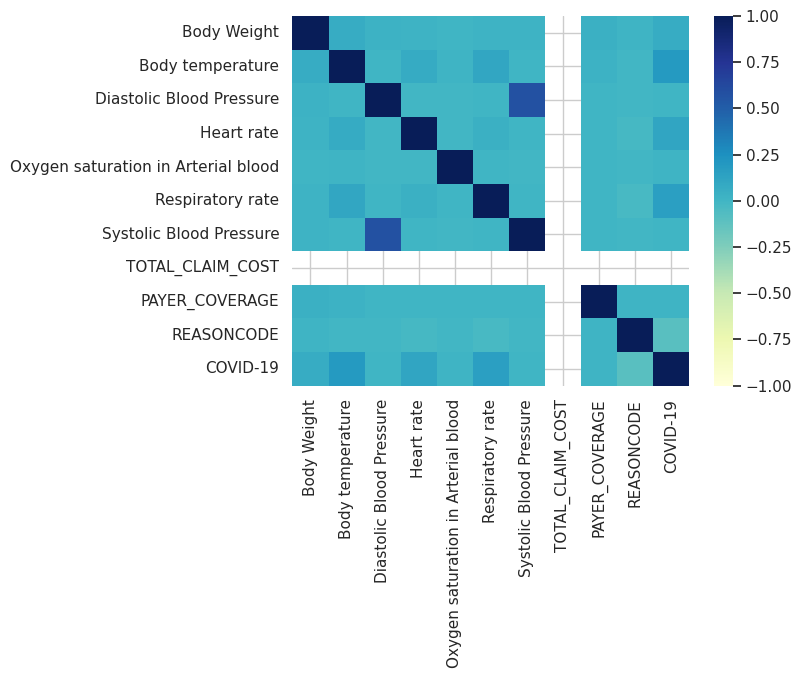

In [ ]:
# Correlation heatmap
sb.heatmap(main_df.corr(), cmap="YlGnBu", annot=False, vmin=-1, vmax=1)

In [ ]:
# Dropping columns based on correlation
main_df = main_df.drop(columns=['TOTAL_CLAIM_COST', 'REASONCODE','ENCOUNTERCLASS'])

In [ ]:
final_resp_df = pd.get_dummies(main_df, columns = ['DESCRIPTION'])

<Axes: >

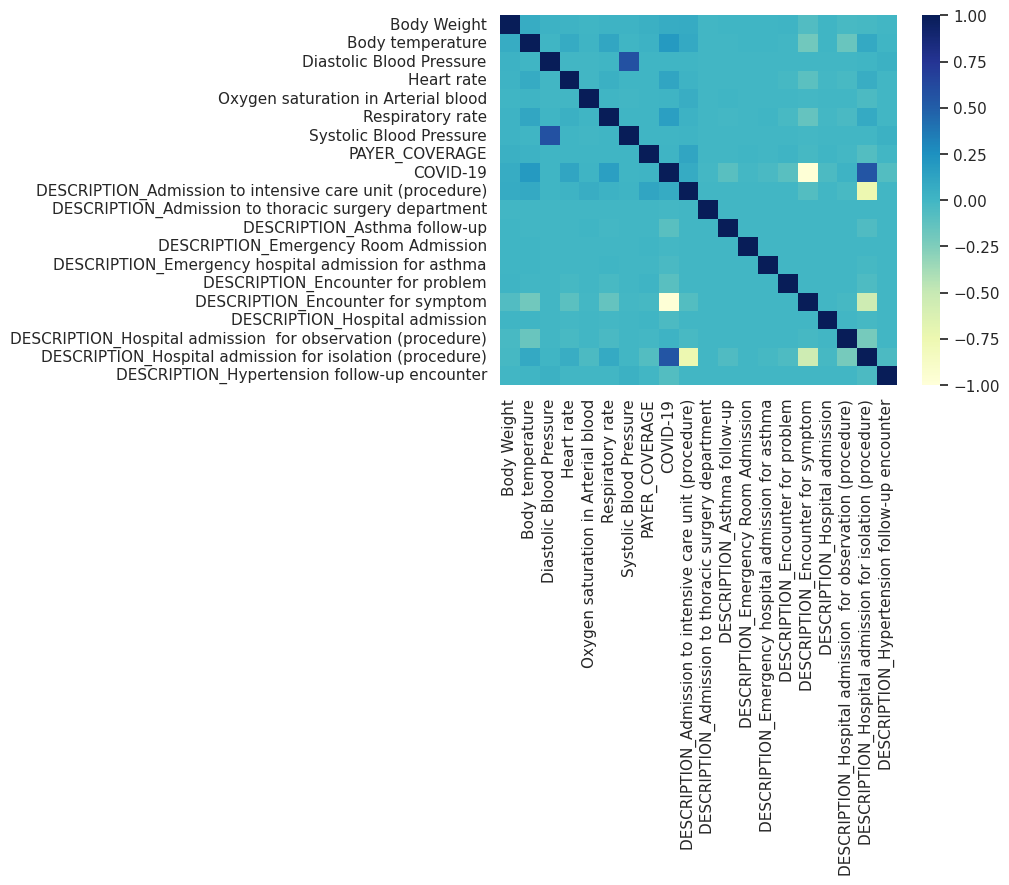

In [ ]:
sb.heatmap(final_resp_df.corr(), cmap="YlGnBu", annot=False, vmin=-1, vmax=1)

In [ ]:
final_resp_df = final_resp_df.drop(columns=['Diastolic Blood Pressure', 'DESCRIPTION_Hospital admission for isolation (procedure)', 'DESCRIPTION_Encounter for symptom'])

In [ ]:
final_resp_df.head()

,Body Weight,Body temperature,Heart rate,Oxygen saturation in Arterial blood,Respiratory rate,Systolic Blood Pressure,PAYER_COVERAGE,COVID-19,DESCRIPTION_Admission to intensive care unit (procedure),DESCRIPTION_Admission to thoracic surgery department,DESCRIPTION_Asthma follow-up,DESCRIPTION_Emergency Room Admission,DESCRIPTION_Emergency hospital admission for asthma,DESCRIPTION_Encounter for problem,DESCRIPTION_Hospital admission,DESCRIPTION_Hospital admission for observation (procedure),DESCRIPTION_Hypertension follow-up encounter
0,16.000000,39.168139,80.000000,81.445462,14.000000,115.000000,0.00,False,0,0,0,0,0,0,0,0,0
1,74.793547,38.000000,110.331552,81.445462,21.851085,121.869208,64.16,False,0,0,0,0,0,0,0,0,0
2,13.000000,39.168139,73.000000,81.445462,14.000000,120.000000,64.16,False,0,0,0,0,0,0,0,0,0
3,74.793547,37.000000,110.331552,81.445462,21.851085,121.869208,0.00,False,0,0,0,0,0,0,0,0,0
4,74.793547,37.000000,110.331552,81.445462,21.851085,121.869208,54.16,False,0,0,0,0,0,0,0,0,0


In [ ]:
# COnverting target column to a 0 1 column for prediction
def covid(x):
  if x == False:
    return 0
  else:
    return 1

In [ ]:
final_resp_df['COVID-19'] = final_resp_df['COVID-19'].apply(covid)

<Axes: >

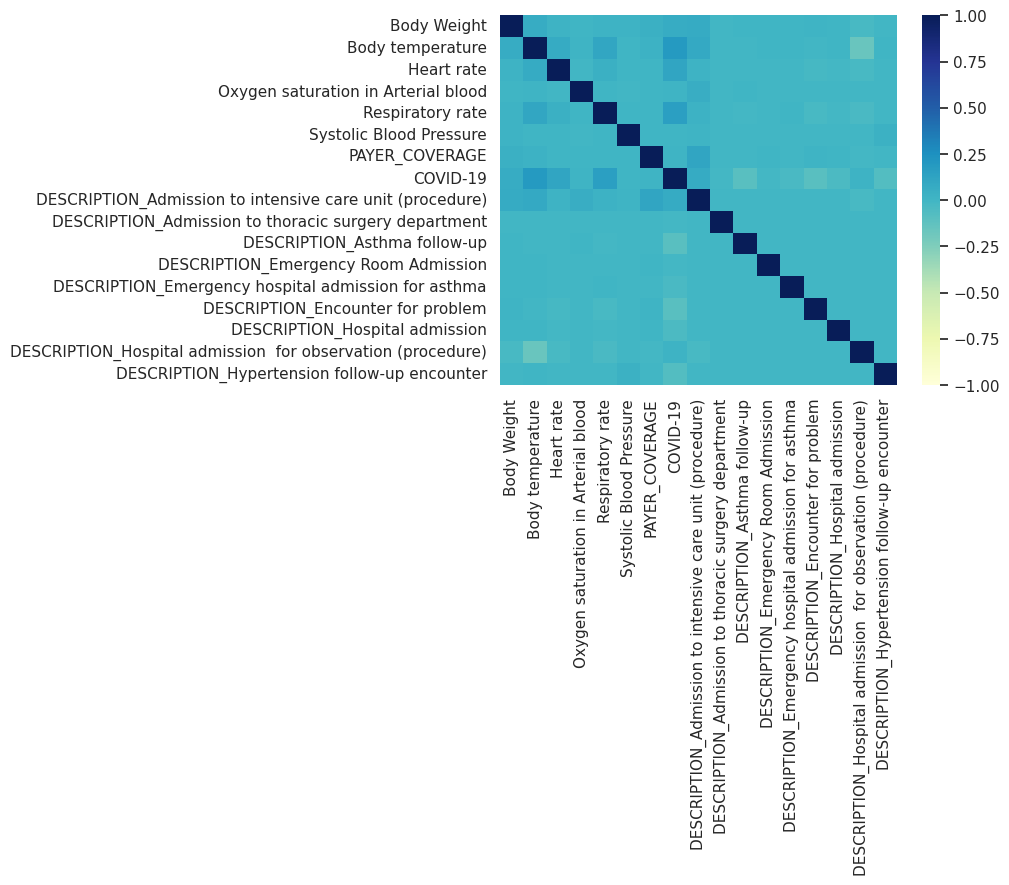

In [ ]:
sb.heatmap(final_resp_df.corr(), cmap="YlGnBu", annot=False, vmin=-1, vmax=1)

In [ ]:
final_resp_df.to_csv('data1.csv')

## Data Loading

In [ ]:
# Load final curated dataset
final_resp_df = pd.read_csv('data1.csv')

In [ ]:
final_resp_df = final_resp_df.drop(columns=['Unnamed: 0'])

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = final_resp_df.loc[:, ~final_resp_df.columns.isin(['COVID-19'])]
df_Y = final_resp_df[['COVID-19']]

<Axes: >

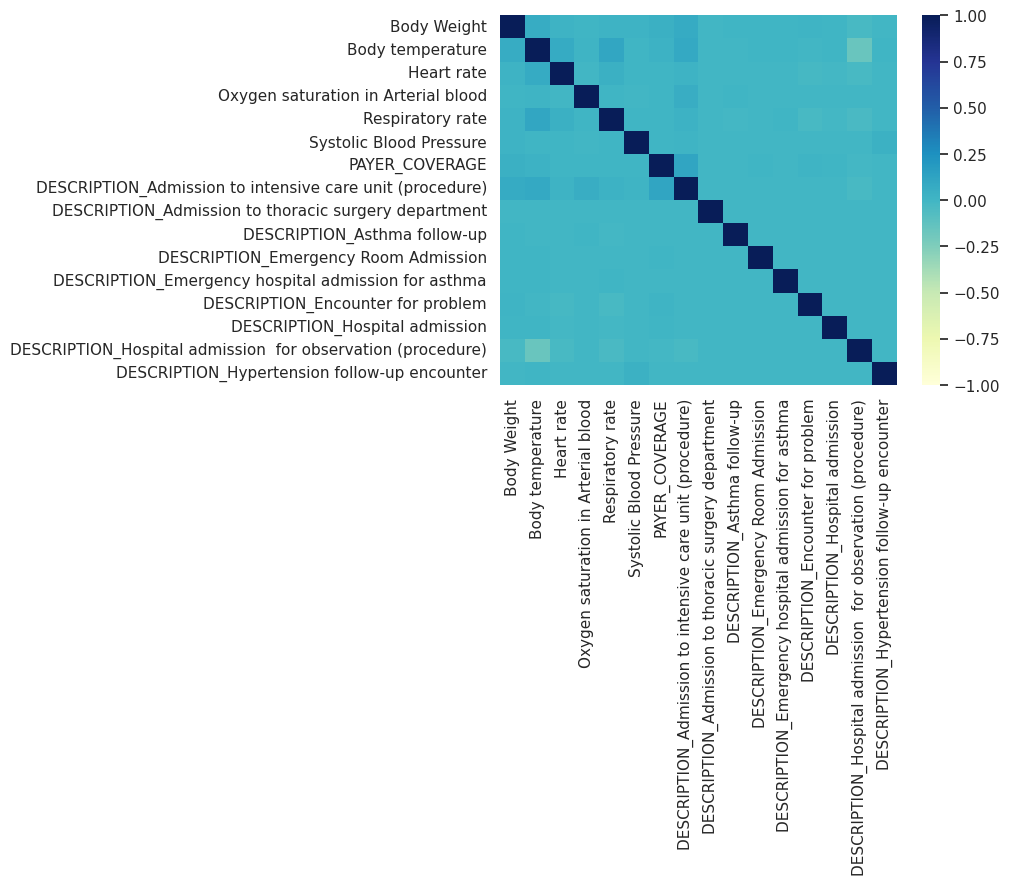

In [ ]:
sb.heatmap(df_X.corr(), cmap="YlGnBu", annot=False, vmin=-1, vmax=1)

In [ ]:
# # Splitting into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 

In [ ]:
# X_train = np.asarray(X_train)
# # X_val = np.asarray(X_val)
# X_test = np.asarray(X_test)

In [ ]:
# y_train = np.asarray(y_train).reshape(-1)
# # y_val = np.asarray(y_val).reshape(-1)
# y_test = np.asarray(y_test).reshape(-1)

In [ ]:
# Using Stratified Shuffle Split 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # To avoid overfitting
for train_index, test_index in split.split(final_resp_df, final_resp_df['COVID-19']):
    strat_train_set = final_resp_df.loc[train_index]
    strat_test_set = final_resp_df.loc[test_index]

# Creating X_train, y_train, X_test, y_test
X_trainval = strat_train_set.loc[:, ~strat_train_set.columns.isin(['COVID-19'])]
y_trainval = strat_train_set[['COVID-19']]

X_test = strat_test_set.loc[:, ~strat_test_set.columns.isin(['COVID-19'])]
y_test = strat_test_set[['COVID-19']]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, random_state=42) 

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_val.shape: ", X_val.shape)
print("y_val.shape: ", y_val.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (139586, 16)
y_train.shape:  (139586, 1)
X_val.shape:  (59823, 16)
y_val.shape:  (59823, 1)
X_test.shape:  (49853, 16)
y_test.shape:  (49853, 1)


In [ ]:
# Standard scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

## Modeling

### Logistic Regression

In [ ]:
# Define logistic regression model
logreg_clf = LogisticRegression()

In [ ]:
# Fitting the model to the scaled training set
logreg_clf.fit(X_train_std,y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression()

In [ ]:
# Generating predictions from the model on the scaled test set
log_preds = logreg_clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, log_preds))

              precision    recall  f1-score   support

           0       0.84      0.03      0.06      2681
           1       0.95      1.00      0.97     47172

    accuracy                           0.95     49853
   macro avg       0.90      0.52      0.52     49853
weighted avg       0.94      0.95      0.92     49853



In [ ]:
# Area Under ROC
print("The ROC-AUC score of logistic regression model = ", roc_auc_score(y_test, log_preds))

The ROC-AUC score of logistic regression model =  0.5158691993647855


#### Logistic Regression with Oversampling

In [ ]:
# Using SMOTE technique to address class imbalance
smote_over = SMOTE()
X_smote_std, y_smote = smote_over.fit_resample(X_train_std, y_train)

In [ ]:
# Define logistic regression model
logreg_clf = LogisticRegression()

In [ ]:
# Fitting the model to the scaled oversampled training set
logreg_clf.fit(X_smote_std,y_smote)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression()

In [ ]:
# Generating predictions from the model on the scaled test set
smote_log_preds = logreg_clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, smote_log_preds))

              precision    recall  f1-score   support

           0       0.19      0.94      0.31      2681
           1       1.00      0.77      0.87     47172

    accuracy                           0.78     49853
   macro avg       0.59      0.86      0.59     49853
weighted avg       0.95      0.78      0.84     49853



In [ ]:
# Area Under ROC
print("The ROC-AUC score of logistic regression model with oversampling = ", roc_auc_score(y_test, smote_log_preds))

The ROC-AUC score of logistic regression model with oversampling =  0.8551869849710438


In [ ]:
final_resp_df.to_csv('final_resp_df')

#### Logistic Regression with Undersampling

In [ ]:
# Using Random Undersampling technique to address class imbalance
ran_under = RandomUnderSampler(sampling_strategy='majority', random_state=42)

In [ ]:
X_ran_std, y_ran = ran_under.fit_resample(X_train_std, y_train)

In [ ]:
# Define logistic regression model
logreg_clf = LogisticRegression()

In [ ]:
# Fitting the model to the scaled undersampled training set
logreg_clf.fit(X_ran_std, y_ran)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression()

In [ ]:
# Generating predictions from the model on the scaled test set
ran_log_preds = logreg_clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, ran_log_preds))

              precision    recall  f1-score   support

           0       0.18      0.94      0.31      2681
           1       1.00      0.76      0.86     47172

    accuracy                           0.77     49853
   macro avg       0.59      0.85      0.59     49853
weighted avg       0.95      0.77      0.83     49853



In [ ]:
# Area Under ROC
print("The ROC-AUC score of logistic regression model with undersampling = ", roc_auc_score(y_test, ran_log_preds))

The ROC-AUC score of logistic regression model with undersampling =  0.8531263868118176


### Gradient Boosting Classifier

#### Gradient Boosting Classifier with Oversampling

In [ ]:
# Defining GB model
gb_clf = GradientBoostingClassifier(learning_rate=0.1, random_state = 42, max_depth=5)

In [ ]:
# Fitting the model on scaled oversampled data
gb_clf.fit(X_smote_std,y_smote)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingClassifier(max_depth=5, random_state=42)

In [ ]:
# Generating predictions from the model on the scaled test set
smote_gb_preds = gb_clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, smote_gb_preds))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81      2681
           1       1.00      0.98      0.99     47172

    accuracy                           0.98     49853
   macro avg       0.85      0.96      0.90     49853
weighted avg       0.98      0.98      0.98     49853



In [ ]:
# Area Under ROC
print("The ROC-AUC score of gradient boosting model with oversampling = ", roc_auc_score(y_test, smote_gb_preds))

The ROC-AUC score of gradient boosting model with oversampling =  0.9644986374907473


Text(0.5, 1.0, 'Feature Importance')

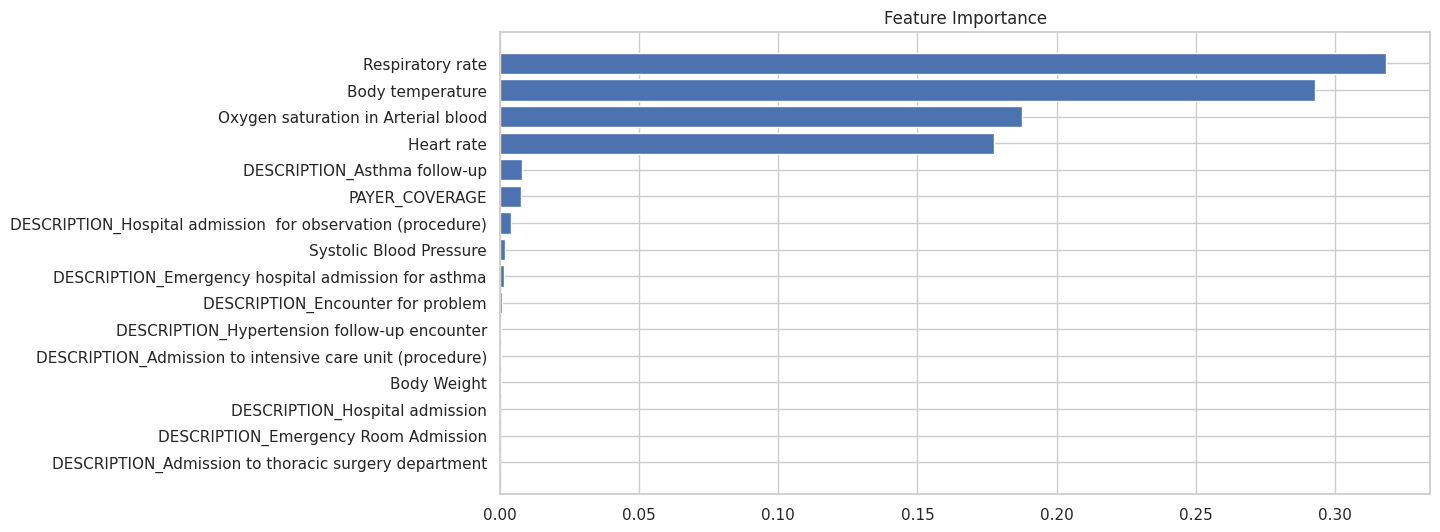

In [ ]:
# Feature importance
feature_importance = gb_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'SHAP Importance')

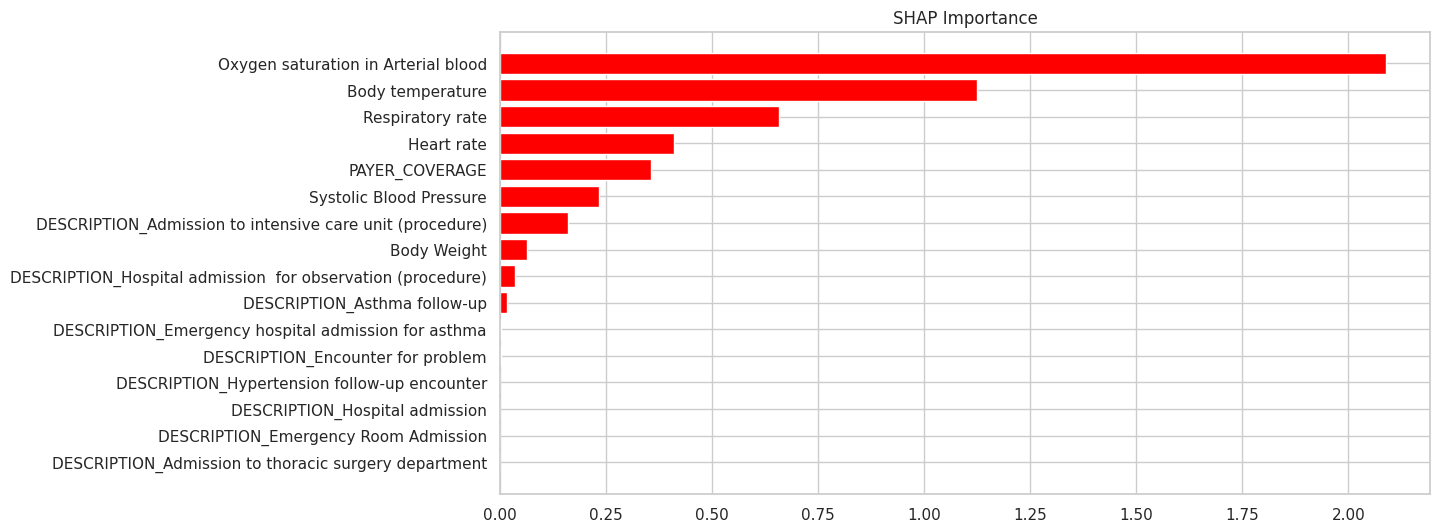

In [ ]:
# SHAP values
explainer = shap.Explainer(gb_clf)
shap_values = explainer(X_test_std)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center', color='red')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')


#### Gradient Boosting Classifier with Undersampling

In [ ]:
# Defining GB model
gb_clf = GradientBoostingClassifier(learning_rate=0.1, random_state = 42, max_depth=5)

In [ ]:
# Fitting the model on scaled undersampled data
gb_clf.fit(X_ran_std,y_ran)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingClassifier(max_depth=5, random_state=42)

In [ ]:
# Generating predictions from the model on the scaled test set
ran_gb_preds = gb_clf.predict(X_test_std)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test, ran_gb_preds))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81      2681
           1       1.00      0.98      0.99     47172

    accuracy                           0.98     49853
   macro avg       0.85      0.96      0.90     49853
weighted avg       0.98      0.98      0.98     49853



In [ ]:
# Area under ROC
print("The ROC-AUC score of gradient boosting model with undersampling = ", roc_auc_score(y_test, ran_gb_preds))

The ROC-AUC score of gradient boosting model with undersampling =  0.964888538086417


### Feed Forward Neural Network

In [ ]:
# Oversampling the validation set
X_val_smote_std, y_val_smote = smote_over.fit_resample(X_val_std, y_val)

In [ ]:
# Defining a FFNN using Keras
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_dim=16))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Optimizer: Adam, Loss: Binary Cross Entropy, Metric: AUC, Epochs: 5
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.AUC(from_logits=True))

model.fit(X_smote_std, y_smote, epochs=5, validation_data=(X_val_smote_std, y_val_smote))

Epoch 1/5
8257/8257 [==============================] - 33s 4ms/step - loss: 0.5802 - auc_1: 0.7440 - val_loss: 0.3551 - val_auc_1: 0.8879
Epoch 2/5
8257/8257 [==============================] - 25s 3ms/step - loss: 0.3027 - auc_1: 0.9396 - val_loss: 0.2480 - val_auc_1: 0.9545
Epoch 3/5
8257/8257 [==============================] - 24s 3ms/step - loss: 0.2431 - auc_1: 0.9538 - val_loss: 0.2198 - val_auc_1: 0.9595
Epoch 4/5
8257/8257 [==============================] - 25s 3ms/step - loss: 0.2295 - auc_1: 0.9562 - val_loss: 0.2226 - val_auc_1: 0.9577
Epoch 5/5
8257/8257 [==============================] - 24s 3ms/step - loss: 0.2239 - auc_1: 0.9577 - val_loss: 0.2184 - val_auc_1: 0.9583


In [ ]:
# Generating predictions from the model on the scaled test set
fnn_preds = model.predict(X_test_std)
print("The ROC-AUC score of fully connected neural network = ", roc_auc_score(y_test, fnn_preds))

1558/1558 [==============================] - 3s 2ms/step
The ROC-AUC score of fully connected neural network =  0.9463169227485704


In [ ]:
# Computing test loss
test_loss, _ = model.evaluate(X_test_std,  y_test, verbose=2)
print("Test loss: ", test_loss)

1558/1558 - 3s - loss: 0.2522 - auc_1: 0.9455 - 3s/epoch - 2ms/step
Test loss:  0.25220799446105957


In [ ]:
y_preds = model.predict(X_test_std) > 0.5

1558/1558 [==============================] - 2s 1ms/step


In [ ]:
# Classification Model
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.37      0.92      0.53      2681
           1       1.00      0.91      0.95     47172

    accuracy                           0.91     49853
   macro avg       0.68      0.92      0.74     49853
weighted avg       0.96      0.91      0.93     49853

